# Facies classification from the 2016 SEG ML contest 

All the data, description is available [here](https://github.com/seg/2016-ml-contest).

This reproductio for the original SVM classification (Brendon Hall) and different classification used to see which method is better. I hope to beat the F1 score for the winner of the contest (0.6388).

Let's begin below!!

In [1]:
## importing libraries used by Brendon Hall
%matplotlib inline
import requests
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

## Downloading the data

In [2]:
# # download .py file to use it
# r = requests.get('https://raw.githubusercontent.com/seg/2016-ml-contest/master/classification_utilities.py')  
# with open('/content/classification_utilities.py', 'wb') as f:
#     f.write(r.content)

In [3]:
# import the new libraries
from classification_utilities import display_cm, display_adj_cm

In [4]:
filename = 'https://raw.githubusercontent.com/seg/2016-ml-contest/master/training_data.csv'
training_data = pd.read_csv(filename)
training_data.head(3)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957


## Preparing the data

In [5]:
# Get the categorical variables
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
print(training_data['Well Name'].unique())
print(training_data['Formation'].unique())

['SHRIMPLIN', 'SHANKLE', 'LUKE G U', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (8, object): ['CHURCHMAN BIBLE', 'CROSS H CATTLE', 'LUKE G U', 'NEWBY', 'NOLAN', 'Recruit F9', 'SHANKLE', 'SHRIMPLIN']
['A1 SH', 'A1 LM', 'B1 SH', 'B1 LM', 'B2 SH', ..., 'B4 LM', 'B5 SH', 'B5 LM', 'C SH', 'C LM']
Length: 14
Categories (14, object): ['A1 LM', 'A1 SH', 'B1 LM', 'B1 SH', ..., 'B5 LM', 'B5 SH', 'C LM', 'C SH']


## Exploratory data analysis 

Following the same code that Brendon Hall uses

In [6]:
# descriptive statistics of the continuos variables
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


In [7]:
# remove one well for a blind test later
blind = training_data[training_data['Well Name'] == 'SHANKLE']
training_data = training_data[training_data['Well Name'] != 'SHANKLE']

In [8]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']

#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}

for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]

training_data.loc[:,'FaciesLabels'] = (training_data
                                       .apply(lambda row: 
                                              label_facies(row, facies_labels), 
                                              axis=1))

In [9]:
# function to print well logs and facies (only works for variables in this dataset)

def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

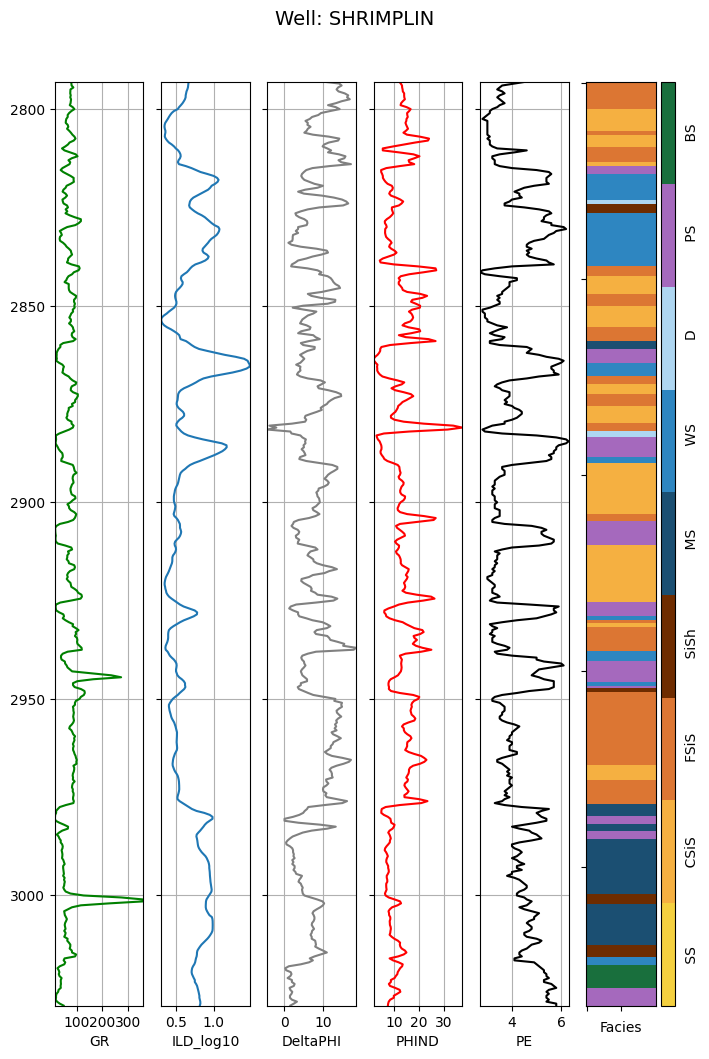

In [10]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

SS      170
CSiS    649
FSiS    498
SiSh    177
MS      198
WS      391
D        81
PS      458
BS      161
Name: Facies, dtype: int64

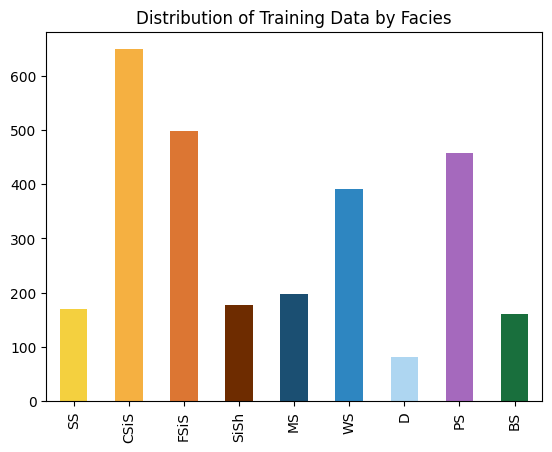

In [11]:
# distribution of the facies

facies_counts = training_data['Facies'].value_counts().sort_index()

facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

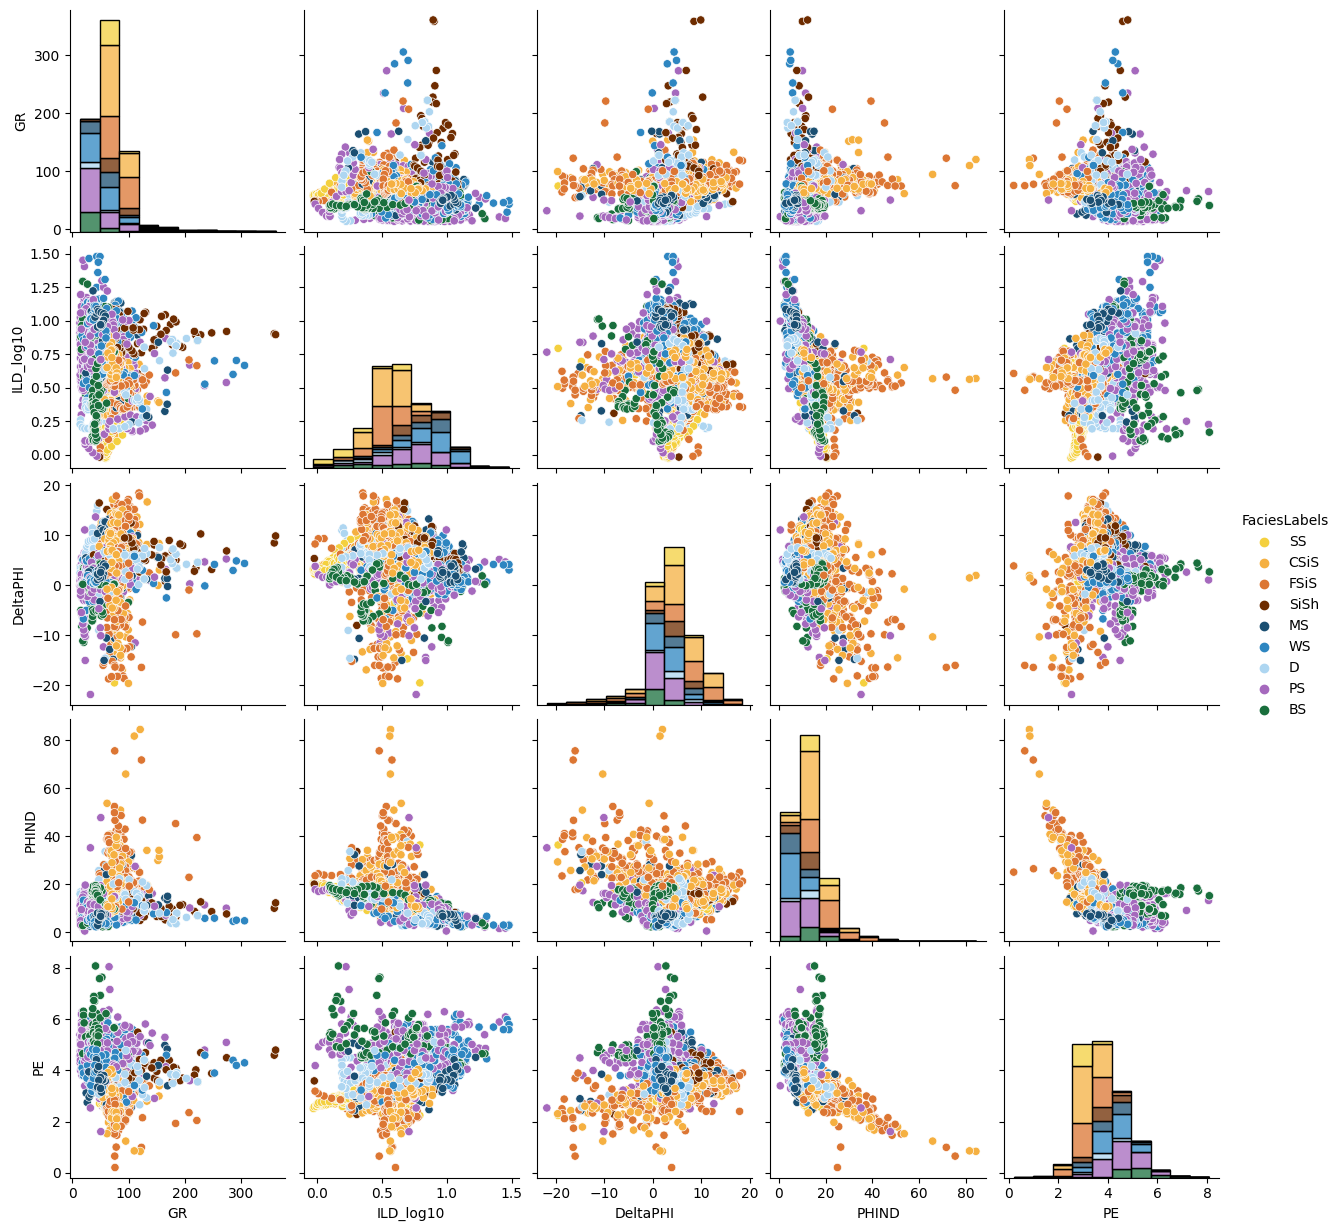

In [12]:
# pairplot
inline_rc = dict(mpl.rcParams)

sns.set_style(rc=inline_rc)
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
            #  hue_order=list(reversed(facies_labels)),
             hue_order=list(facies_labels),
             diag_kind='hist',
             diag_kws={'multiple': 'stack',
                       'bins':10})

In [13]:
# get only the values to the classification
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000
mean,66.249445,0.644637,3.754963,13.118929,3.805693,1.523895,0.523057
std,31.610849,0.241922,5.045916,7.389665,0.894118,0.499518,0.287499
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.081500,0.497000,1.300000,8.165000,3.200000,1.000000,0.276500
50%,65.541000,0.627000,3.581000,11.900000,3.600000,2.000000,0.529000
75%,80.714000,0.812323,6.500000,16.144000,4.400000,2.000000,0.771500
max,361.150000,1.480000,18.500000,84.400000,8.094000,2.000000,1.000000


## Generating the train-test dataframes

In [14]:
# standarization of the data (zero mean and unit variance, the "whitening")
scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [15]:
# creating the train-test dataset 
X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.1, random_state=42)

## Support Vector Machine (SVM) classification solution!

We uses the Brendon Hall code for the SVM solution

In [16]:
clf = svm.SVC()

In [17]:
clf.fit(X_train,y_train)

SVC()

In [18]:
predicted_labels = clf.predict(X_test)

In [19]:
# confusion matrzi visualization
conf = confusion_matrix(y_test, predicted_labels)

In [20]:
display_cm(conf, facies_labels, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    12    11     1                                        24
     CSiS          40    18                                        58
     FSiS          18    22                                        40
     SiSh           1          10           4           1          16
       MS           1           2          21     1     5          30
       WS                       1          23           9     2    35
        D                       1                 5     5          11
       PS                             2    10          37     2    51
       BS                                   1           3    10    14


/home/juanxo90/Dev/facies_classification/classification_utilities.py:15: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall)


In [21]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [22]:
def accuracy_np(conf):
    total_correct = np.trace(conf)
    acc = total_correct/sum(sum(conf))
    return acc

In [23]:
%%time
accuracy(conf)

CPU times: user 75 µs, sys: 6 µs, total: 81 µs
Wall time: 84.4 µs


0.5698924731182796

In [24]:
%%time
accuracy_np(conf)

CPU times: user 62 µs, sys: 0 ns, total: 62 µs
Wall time: 65.6 µs


0.5698924731182796

In [25]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]], dtype='object')

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [26]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.569892
Adjacent facies classification accuracy = 0.924731


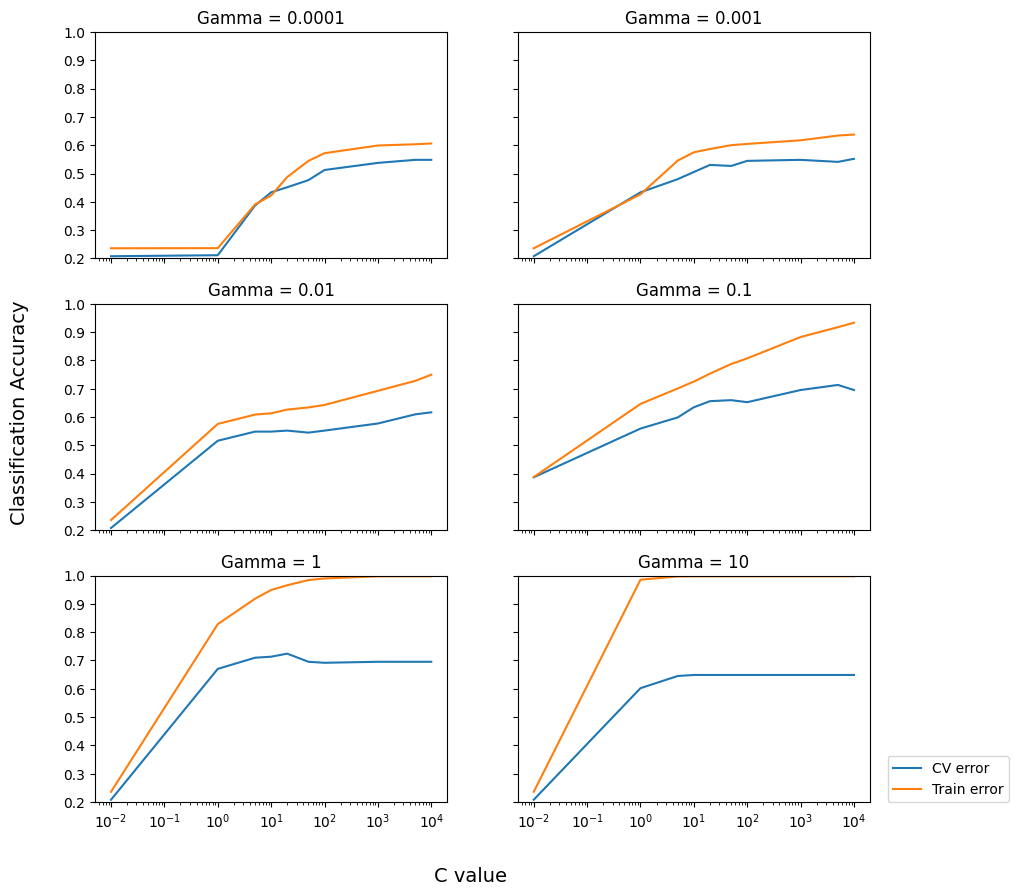

In [27]:
#model selection takes a few minutes, change this variable
#to true to run the parameter loop
do_model_selection = True

if do_model_selection:
    C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
    gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
    
    fig, axes = plt.subplots(3, 2, 
                        sharex='col', sharey='row',figsize=(10,10))
    plot_number = 0
    for outer_ind, gamma_value in enumerate(gamma_range):
        row = int(plot_number / 2)
        column = int(plot_number % 2)
        cv_errors = np.zeros(C_range.shape)
        train_errors = np.zeros(C_range.shape)
        for index, c_value in enumerate(C_range):
            
            clf = svm.SVC(C=c_value, gamma=gamma_value)
            clf.fit(X_train,y_train)
            
            train_conf = confusion_matrix(y_train, clf.predict(X_train))
            cv_conf = confusion_matrix(y_test, clf.predict(X_test))
        
            cv_errors[index] = accuracy(cv_conf)
            train_errors[index] = accuracy(train_conf)

        ax = axes[row, column]
        ax.set_title('Gamma = %g'%gamma_value)
        ax.semilogx(C_range, cv_errors, label='CV error')
        ax.semilogx(C_range, train_errors, label='Train error')
        plot_number += 1
        ax.set_ylim([0.2,1])
        
    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    fig.text(0.5, 0.03, 'C value', ha='center',
             fontsize=14)
             
    fig.text(0.04, 0.5, 'Classification Accuracy', va='center', 
             rotation='vertical', fontsize=14)

In [28]:
clf = svm.SVC(C=10, gamma=1)        
clf.fit(X_train, y_train)

cv_conf = confusion_matrix(y_test, clf.predict(X_test))

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.71
Optimized adjacent facies classification accuracy = 0.93


In [29]:
display_cm(cv_conf, facies_labels, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    18     5     1                                        24
     CSiS     1    48     9                                        58
     FSiS     1    13    25           1                            40
     SiSh           1     1    12           1           1          16
       MS           1           2    14    10           3          30
       WS                       3     4    23     1     4          35
        D                       1     2           8                11
       PS                             2     9          40          51
       BS                                               3    11    14

Precision  0.90  0.71  0.69  0.67  0.61  0.53  0.89  0.78  1.00  0.72
   Recall  0.75  0.83  0.62  0.75  0.47  0.66  0.73  0.78  0.79  0.71
       F1  0.82  0.76  0.66  0.71  0.53  0.59  0.80  0.78  0.88  0.71


In [30]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    23           1                                        24
     CSiS          58                                              58
     FSiS     1          38           1                            40
     SiSh           1     1    12           1           1          16
       MS           1                26                 3          30
       WS                       3          32                      35
        D                       1     2           8                11
       PS                             2                49          51
       BS                                                    14    14

Precision  0.96  0.97  0.95  0.75  0.84  0.97  1.00  0.92  1.00  0.93
   Recall  0.96  1.00  0.95  0.75  0.87  0.91  0.73  0.96  1.00  0.93
       F1  0.96  0.98  0.95  0.75  0.85  0.94  0.84  0.94  1.00  0.93


In [31]:
# applying the classification in the blind data
blind.head(10)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
471,2,A1 SH,SHANKLE,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000
472,2,A1 SH,SHANKLE,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984
473,2,A1 SH,SHANKLE,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968
474,2,A1 SH,SHANKLE,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952
475,2,A1 SH,SHANKLE,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935
476,2,A1 SH,SHANKLE,2777.0,82.56,0.599,12.9,13.105,3.5,1,0.919
477,2,A1 SH,SHANKLE,2777.5,83.12,0.611,13.2,14.000,3.3,1,0.903
478,2,A1 SH,SHANKLE,2778.0,84.26,0.620,12.8,13.685,3.3,1,0.887
479,2,A1 SH,SHANKLE,2778.5,86.29,0.627,13.2,13.920,3.2,1,0.871
480,2,A1 SH,SHANKLE,2779.0,80.95,0.629,13.0,13.975,3.2,1,0.855


In [32]:
y_blind = blind['Facies'].values
well_features = blind.drop(['Facies', 'Formation', 'Well Name', 'Depth'], axis=1)

In [33]:
X_blind = scaler.transform(well_features)

In [34]:
y_pred = clf.predict(X_blind)
blind_svc = blind.copy()
blind_svc['Prediction'] = y_pred

In [35]:
blind_svc['Prediction'].unique()

array([2, 3, 1, 8, 9, 6, 5, 4, 7])

In [36]:
cv_conf = confusion_matrix(y_blind, y_pred)

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.45
Optimized adjacent facies classification accuracy = 0.88


In [37]:
display_cm(cv_conf, facies_labels,
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS     9    60    20                                        89
     CSiS    15    61    13                                        89
     FSiS     2    52    63                                       117
     SiSh                       2           5                       7
       MS                       3     3     2           9     2    19
       WS                 3     3    11    39          15          71
        D                 5     3     1           2     6          17
       PS                             2    14     2    21     1    40
       BS                                                           0

Precision  0.35  0.35  0.61  0.18  0.18  0.65  0.50  0.41  0.00  0.47
   Recall  0.10  0.69  0.54  0.29  0.16  0.55  0.12  0.53  0.00  0.45
       F1  0.16  0.47  0.57  0.22  0.17  0.60  0.19  0.46  0.00  0.42


/home/juanxo90/Dev/facies_classification/classification_utilities.py:14: RuntimeWarning: invalid value encountered in true_divide
  recall = np.diagonal(cm)/cm.sum(axis=1).astype('float')


In [38]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    69          20                                        89
     CSiS          89                                              89
     FSiS     2         115                                       117
     SiSh                       2           5                       7
       MS                             8                 9     2    19
       WS                 3     3          65                      71
        D                 5     3     1           8                17
       PS                             2                38          40
       BS                                                           0

Precision  0.97  1.00  0.80  0.25  0.73  0.93  1.00  0.81  0.00  0.89
   Recall  0.78  1.00  0.98  0.29  0.42  0.92  0.47  0.95  0.00  0.88
       F1  0.86  1.00  0.88  0.27  0.53  0.92  0.64  0.87  0.00  0.87


In [39]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

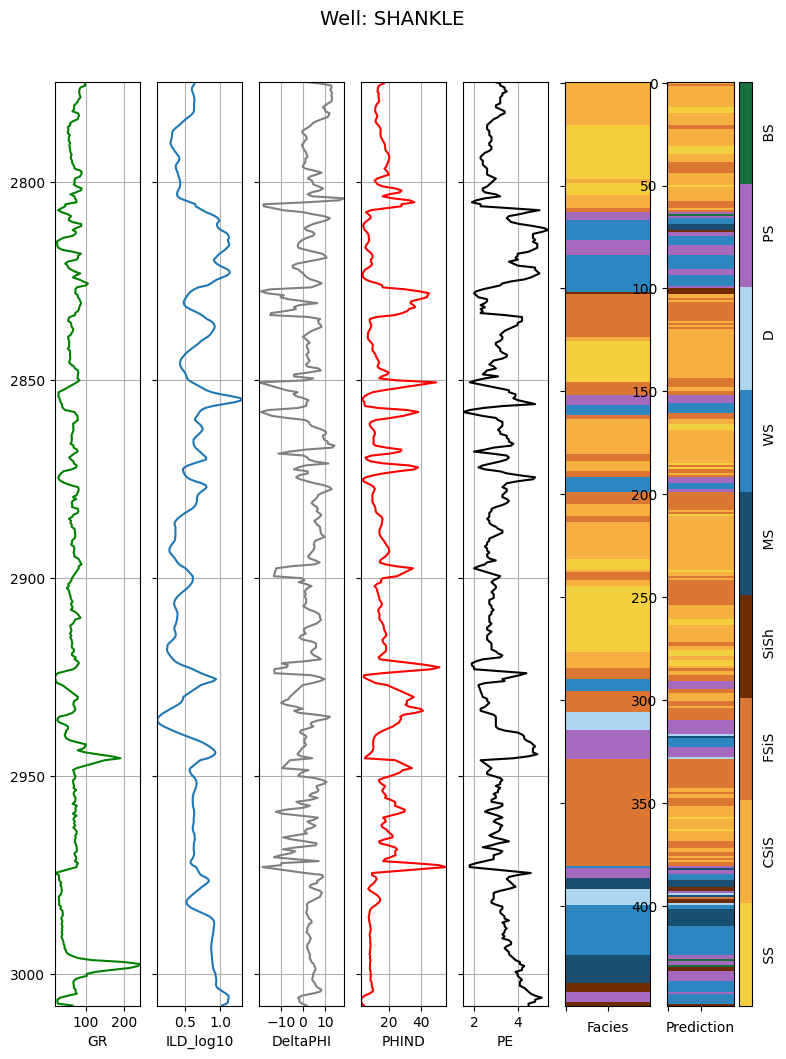

In [40]:
# comparison between results and blind
compare_facies_plot(blind_svc, 'Prediction', facies_colors)

In [41]:
# applying on the training dataset
validation_url = 'https://raw.githubusercontent.com/seg/2016-ml-contest/master/validation_data_nofacies.csv'
well_data = pd.read_csv(validation_url)
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_features = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)

In [42]:
X_unknown = scaler.transform(well_features)

In [43]:
#predict facies of unclassified data
y_unknown = clf.predict(X_unknown)
well_data['Facies'] = y_unknown
well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,3
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,3
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,1
...,...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,3
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,3
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,3
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,3


In [44]:
well_data['Well Name'].unique()

['STUART', 'CRAWFORD']
Categories (2, object): ['CRAWFORD', 'STUART']

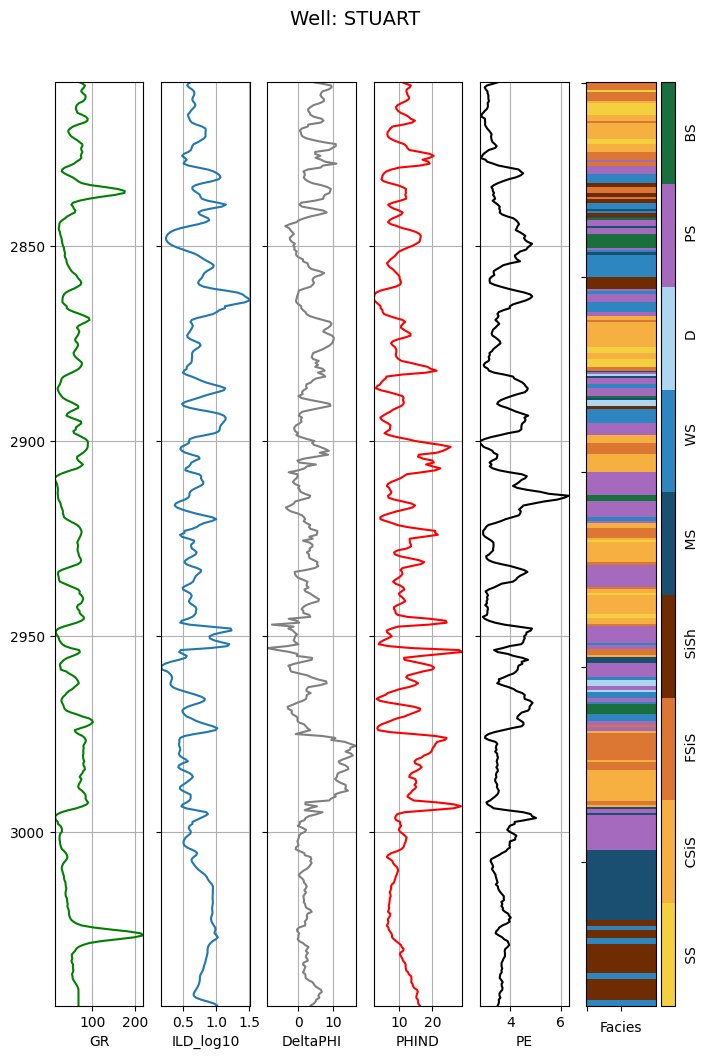

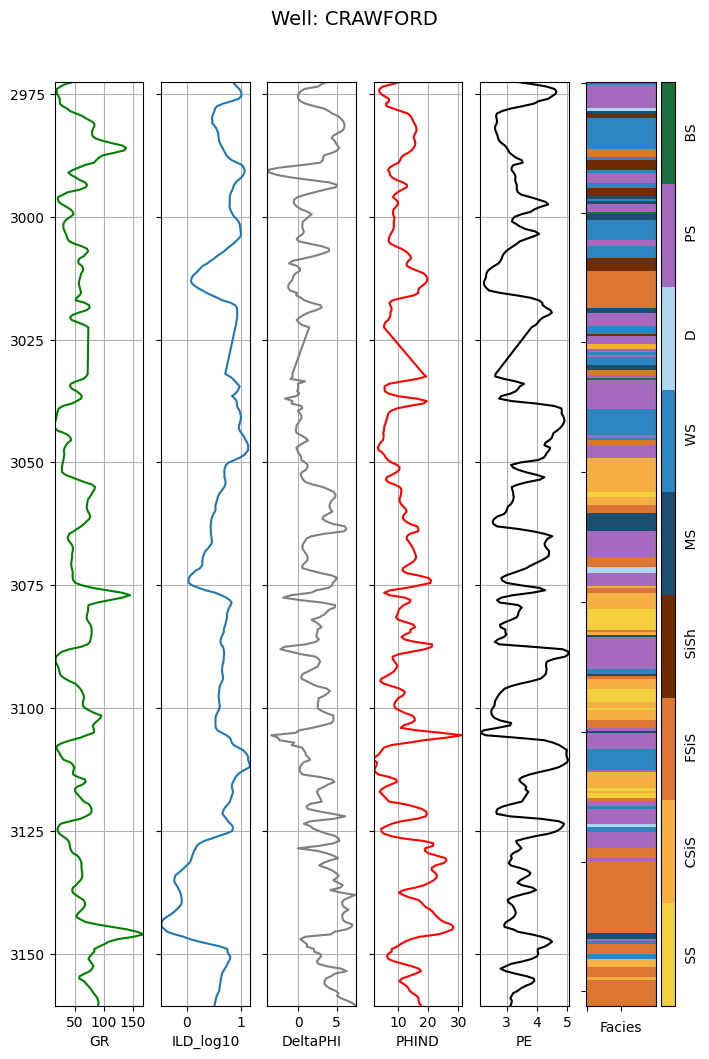

In [45]:
make_facies_log_plot(
    well_data[well_data['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

make_facies_log_plot(
    well_data[well_data['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)

## CatBoost classifier

This section will follow my solution to the problem...

Can CatBoost beat the winner metric?

In [46]:
# %%capture
# !pip install catboost

In [48]:
from catboost import CatBoostClassifier

In [67]:
cbt = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1,
    task_type="GPU",
    #loss_function='CrossEntropy'
)

cbt.fit(X_train, y_train, 
        eval_set=(X_test, y_test), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(cbt.is_fitted()))
print('CatBoost model parameters:')
print(cbt.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 5, 'learning_rate': 0.1, 'task_type': 'GPU'}


In [83]:
cbt = CatBoostClassifier(
    iterations=600,
    task_type="GPU",
#     verbose=5,
)

cbt.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
)

Learning rate set to 0.144225
0:	learn: 1.9052413	test: 1.9511334	best: 1.9511334 (0)	total: 14.8ms	remaining: 8.89s
1:	learn: 1.7127703	test: 1.7649181	best: 1.7649181 (1)	total: 28.5ms	remaining: 8.53s
2:	learn: 1.5823464	test: 1.6396751	best: 1.6396751 (2)	total: 42.7ms	remaining: 8.49s
3:	learn: 1.4785408	test: 1.5472794	best: 1.5472794 (3)	total: 55.5ms	remaining: 8.28s
4:	learn: 1.3930951	test: 1.4656836	best: 1.4656836 (4)	total: 68.3ms	remaining: 8.12s
5:	learn: 1.3212292	test: 1.3953127	best: 1.3953127 (5)	total: 81.2ms	remaining: 8.04s
6:	learn: 1.2636009	test: 1.3401420	best: 1.3401420 (6)	total: 94.3ms	remaining: 7.99s
7:	learn: 1.2152152	test: 1.2953692	best: 1.2953692 (7)	total: 107ms	remaining: 7.88s
8:	learn: 1.1727638	test: 1.2595983	best: 1.2595983 (8)	total: 120ms	remaining: 7.88s
9:	learn: 1.1371652	test: 1.2250839	best: 1.2250839 (9)	total: 131ms	remaining: 7.76s
10:	learn: 1.1027740	test: 1.1928118	best: 1.1928118 (10)	total: 144ms	remaining: 7.72s
11:	learn: 1.07

105:	learn: 0.5482346	test: 0.8601099	best: 0.8601099 (105)	total: 1.44s	remaining: 6.72s
106:	learn: 0.5471913	test: 0.8607359	best: 0.8601099 (105)	total: 1.46s	remaining: 6.71s
107:	learn: 0.5450352	test: 0.8604527	best: 0.8601099 (105)	total: 1.47s	remaining: 6.7s
108:	learn: 0.5426002	test: 0.8602565	best: 0.8601099 (105)	total: 1.48s	remaining: 6.69s
109:	learn: 0.5411670	test: 0.8604382	best: 0.8601099 (105)	total: 1.5s	remaining: 6.68s
110:	learn: 0.5398816	test: 0.8601780	best: 0.8601099 (105)	total: 1.51s	remaining: 6.66s
111:	learn: 0.5382809	test: 0.8598219	best: 0.8598219 (111)	total: 1.53s	remaining: 6.65s
112:	learn: 0.5354121	test: 0.8586385	best: 0.8586385 (112)	total: 1.54s	remaining: 6.63s
113:	learn: 0.5342402	test: 0.8578677	best: 0.8578677 (113)	total: 1.55s	remaining: 6.61s
114:	learn: 0.5315112	test: 0.8579523	best: 0.8578677 (113)	total: 1.56s	remaining: 6.6s
115:	learn: 0.5289704	test: 0.8580778	best: 0.8578677 (113)	total: 1.58s	remaining: 6.58s
116:	learn: 0

201:	learn: 0.3935458	test: 0.8247376	best: 0.8247376 (201)	total: 3.1s	remaining: 6.1s
202:	learn: 0.3912984	test: 0.8245674	best: 0.8245674 (202)	total: 3.11s	remaining: 6.08s
203:	learn: 0.3902682	test: 0.8234645	best: 0.8234645 (203)	total: 3.12s	remaining: 6.07s
204:	learn: 0.3888932	test: 0.8221130	best: 0.8221130 (204)	total: 3.14s	remaining: 6.05s
205:	learn: 0.3872102	test: 0.8204896	best: 0.8204896 (205)	total: 3.15s	remaining: 6.03s
206:	learn: 0.3856004	test: 0.8190610	best: 0.8190610 (206)	total: 3.17s	remaining: 6.01s
207:	learn: 0.3842399	test: 0.8195073	best: 0.8190610 (206)	total: 3.19s	remaining: 6s
208:	learn: 0.3826703	test: 0.8187064	best: 0.8187064 (208)	total: 3.2s	remaining: 6s
209:	learn: 0.3812063	test: 0.8174458	best: 0.8174458 (209)	total: 3.22s	remaining: 5.98s
210:	learn: 0.3797363	test: 0.8180314	best: 0.8174458 (209)	total: 3.24s	remaining: 5.97s
211:	learn: 0.3780045	test: 0.8172405	best: 0.8172405 (211)	total: 3.25s	remaining: 5.96s
212:	learn: 0.37657

302:	learn: 0.2917605	test: 0.7995980	best: 0.7988583 (292)	total: 4.75s	remaining: 4.66s
303:	learn: 0.2909597	test: 0.7990904	best: 0.7988583 (292)	total: 4.76s	remaining: 4.64s
304:	learn: 0.2903414	test: 0.7983089	best: 0.7983089 (304)	total: 4.78s	remaining: 4.62s
305:	learn: 0.2895675	test: 0.7989217	best: 0.7983089 (304)	total: 4.8s	remaining: 4.61s
306:	learn: 0.2890738	test: 0.7991334	best: 0.7983089 (304)	total: 4.81s	remaining: 4.59s
307:	learn: 0.2885601	test: 0.7990352	best: 0.7983089 (304)	total: 4.83s	remaining: 4.58s
308:	learn: 0.2880250	test: 0.7981779	best: 0.7981779 (308)	total: 4.85s	remaining: 4.56s
309:	learn: 0.2870710	test: 0.7980510	best: 0.7980510 (309)	total: 4.86s	remaining: 4.55s
310:	learn: 0.2866793	test: 0.7979103	best: 0.7979103 (310)	total: 4.88s	remaining: 4.54s
311:	learn: 0.2863138	test: 0.7978173	best: 0.7978173 (311)	total: 4.91s	remaining: 4.53s
312:	learn: 0.2851004	test: 0.7989325	best: 0.7978173 (311)	total: 4.94s	remaining: 4.53s
313:	learn:

394:	learn: 0.2343329	test: 0.7987237	best: 0.7972015 (355)	total: 6.43s	remaining: 3.34s
395:	learn: 0.2337255	test: 0.7988369	best: 0.7972015 (355)	total: 6.45s	remaining: 3.32s
396:	learn: 0.2332633	test: 0.7984153	best: 0.7972015 (355)	total: 6.46s	remaining: 3.31s
397:	learn: 0.2327438	test: 0.7986666	best: 0.7972015 (355)	total: 6.48s	remaining: 3.29s
398:	learn: 0.2322589	test: 0.7992809	best: 0.7972015 (355)	total: 6.5s	remaining: 3.27s
399:	learn: 0.2317130	test: 0.7993779	best: 0.7972015 (355)	total: 6.52s	remaining: 3.26s
400:	learn: 0.2312143	test: 0.7988368	best: 0.7972015 (355)	total: 6.55s	remaining: 3.25s
401:	learn: 0.2306131	test: 0.7986391	best: 0.7972015 (355)	total: 6.58s	remaining: 3.24s
402:	learn: 0.2298234	test: 0.7983939	best: 0.7972015 (355)	total: 6.59s	remaining: 3.22s
403:	learn: 0.2294429	test: 0.7986192	best: 0.7972015 (355)	total: 6.61s	remaining: 3.21s
404:	learn: 0.2288099	test: 0.7983398	best: 0.7972015 (355)	total: 6.63s	remaining: 3.19s
405:	learn:

495:	learn: 0.1890383	test: 0.8051646	best: 0.7972015 (355)	total: 8.1s	remaining: 1.7s
496:	learn: 0.1888568	test: 0.8048760	best: 0.7972015 (355)	total: 8.12s	remaining: 1.68s
497:	learn: 0.1885241	test: 0.8046247	best: 0.7972015 (355)	total: 8.14s	remaining: 1.67s
498:	learn: 0.1880844	test: 0.8048652	best: 0.7972015 (355)	total: 8.15s	remaining: 1.65s
499:	learn: 0.1875821	test: 0.8045243	best: 0.7972015 (355)	total: 8.17s	remaining: 1.63s
500:	learn: 0.1871224	test: 0.8041569	best: 0.7972015 (355)	total: 8.18s	remaining: 1.62s
501:	learn: 0.1868910	test: 0.8041492	best: 0.7972015 (355)	total: 8.2s	remaining: 1.6s
502:	learn: 0.1864517	test: 0.8036920	best: 0.7972015 (355)	total: 8.21s	remaining: 1.58s
503:	learn: 0.1862241	test: 0.8030860	best: 0.7972015 (355)	total: 8.23s	remaining: 1.57s
504:	learn: 0.1858805	test: 0.8022577	best: 0.7972015 (355)	total: 8.24s	remaining: 1.55s
505:	learn: 0.1855998	test: 0.8011795	best: 0.7972015 (355)	total: 8.26s	remaining: 1.53s
506:	learn: 0.

592:	learn: 0.1591210	test: 0.8085807	best: 0.7972015 (355)	total: 9.57s	remaining: 113ms
593:	learn: 0.1589637	test: 0.8081668	best: 0.7972015 (355)	total: 9.59s	remaining: 96.8ms
594:	learn: 0.1587352	test: 0.8082834	best: 0.7972015 (355)	total: 9.6s	remaining: 80.7ms
595:	learn: 0.1586258	test: 0.8082203	best: 0.7972015 (355)	total: 9.61s	remaining: 64.5ms
596:	learn: 0.1583648	test: 0.8079174	best: 0.7972015 (355)	total: 9.63s	remaining: 48.4ms
597:	learn: 0.1580752	test: 0.8072984	best: 0.7972015 (355)	total: 9.64s	remaining: 32.2ms
598:	learn: 0.1576616	test: 0.8068227	best: 0.7972015 (355)	total: 9.65s	remaining: 16.1ms
599:	learn: 0.1575346	test: 0.8068233	best: 0.7972015 (355)	total: 9.67s	remaining: 0us
bestTest = 0.7972015053
bestIteration = 355
Shrink model to first 356 iterations.


In [78]:
print(cbt.predict_proba(X_test))

[[0.17106039 0.55957073 0.23678403 ... 0.00557079 0.00579064 0.00175391]
 [0.01878677 0.67708065 0.23833377 ... 0.01375151 0.01347576 0.00500661]
 [0.00146476 0.00232263 0.00300094 ... 0.0084383  0.11032908 0.02341929]
 ...
 [0.02339271 0.03409201 0.03881437 ... 0.10740317 0.07770926 0.00997829]
 [0.0082709  0.01824001 0.01038819 ... 0.03773    0.11505575 0.02198797]
 [0.92532797 0.02564684 0.01606885 ... 0.00409793 0.00842564 0.00397083]]


In [101]:
np.unique(y_test)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [134]:
cbt = CatBoostClassifier(
    iterations=1000,
    random_seed=42,
    learning_rate=0.5,
    custom_loss=['F1', 'Accuracy'],
    task_type="GPU",
    use_best_model=True, 
    depth = 6
)

cbt.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [135]:
predicted_labels_CBC = cbt.predict(X_test)

In [136]:
conf_CBC = confusion_matrix(y_test, predicted_labels_CBC)

In [137]:
display_cm(conf_CBC, facies_labels, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    17     7                                              24
     CSiS          49     9                                        58
     FSiS     1    12    27                                        40
     SiSh           1          13           2                      16
       MS                 1     1    14    12           2          30
       WS                       1     3    26           5          35
        D                                         8     3          11
       PS                       1     4     6          40          51
       BS                                               3    11    14


In [138]:
print('Facies classification accuracy CB = %f' % accuracy(conf_CBC))
print('Adjacent facies classification accuracy CB = %f' % accuracy_adjacent(conf_CBC, adjacent_facies))

Facies classification accuracy CB = 0.734767
Adjacent facies classification accuracy CB = 0.953405


In [159]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.569892
Adjacent facies classification accuracy = 0.924731


In [140]:
y_pred_cb = cbt.predict(X_blind)
blind_cb = blind.copy()
blind_cb['Prediction'] = y_pred_cb

In [141]:
cv_conf_CBC = confusion_matrix(y_blind, y_pred_cb)

In [145]:
display_cm(cv_conf_CBC, facies_labels, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS     3    84     2                                        89
     CSiS     9    69    11                                        89
     FSiS     2    50    62           2                 1         117
     SiSh                       1           4           2           7
       MS                      10     3     3           3          19
       WS                 1     3    10    42          15          71
        D                             2     3    11     1          17
       PS                                  16     1    22     1    40
       BS                                                           0

Precision  0.21  0.34  0.82  0.07  0.18  0.62  0.92  0.50  0.00  0.51
   Recall  0.03  0.78  0.53  0.14  0.16  0.59  0.65  0.55  0.00  0.47
       F1  0.06  0.47  0.64  0.10  0.17  0.60  0.76  0.52  0.00  0.45


In [146]:
display_cm(cv_conf, facies_labels, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS     9    60    20                                        89
     CSiS    15    61    13                                        89
     FSiS     2    52    63                                       117
     SiSh                       2           5                       7
       MS                       3     3     2           9     2    19
       WS                 3     3    11    39          15          71
        D                 5     3     1           2     6          17
       PS                             2    14     2    21     1    40
       BS                                                           0

Precision  0.35  0.35  0.61  0.18  0.18  0.65  0.50  0.41  0.00  0.47
   Recall  0.10  0.69  0.54  0.29  0.16  0.55  0.12  0.53  0.00  0.45
       F1  0.16  0.47  0.57  0.22  0.17  0.60  0.19  0.46  0.00  0.42


In [148]:
print('Facies classification accuracy CBC = %.2f' % accuracy(cv_conf_CBC))
print('Adjacent facies classification accuracy CBC = %.2f' % accuracy_adjacent(cv_conf_CBC, adjacent_facies))

Facies classification accuracy CBC = 0.47
Adjacent facies classification accuracy CBC = 0.95


In [149]:
print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.45
Optimized adjacent facies classification accuracy = 0.88


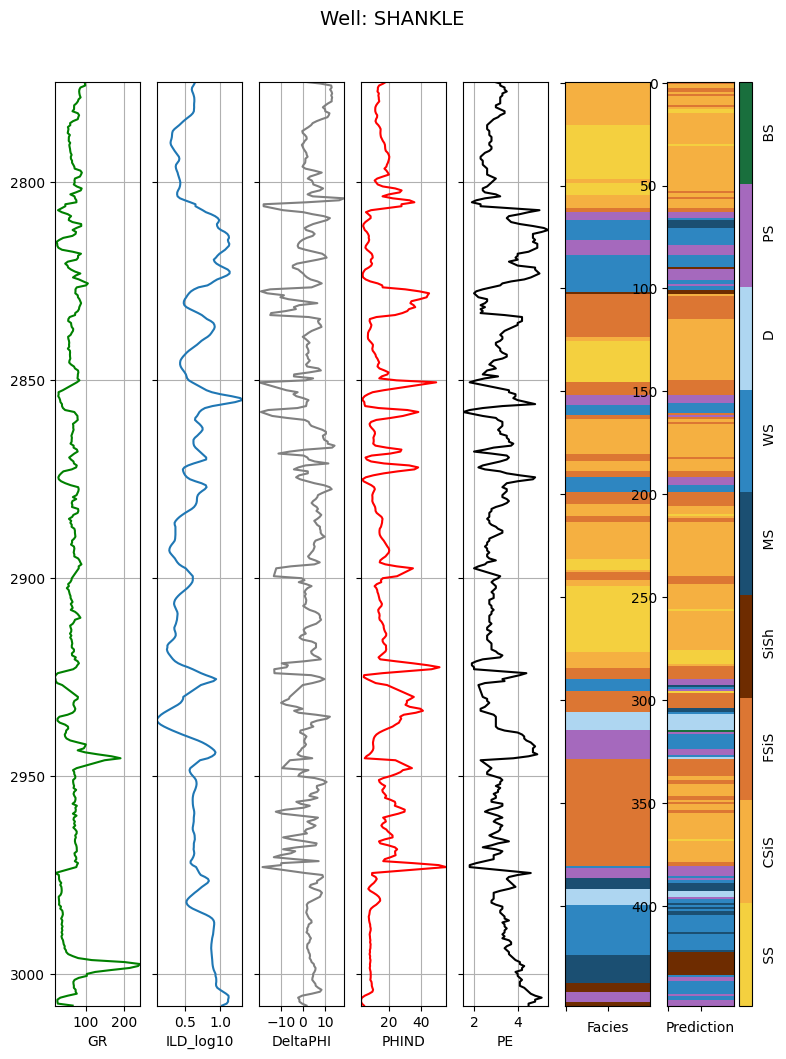

In [150]:
# comparison between results and blind
compare_facies_plot(blind_cb, 'Prediction', facies_colors)

In [151]:
# applying on the no facies
validation_url = 'https://raw.githubusercontent.com/seg/2016-ml-contest/master/validation_data_nofacies.csv'
well_data_cb = pd.read_csv(validation_url)
well_data_cb['Well Name'] = well_data_cb['Well Name'].astype('category')
well_features_cb = well_data_cb.drop(['Formation', 'Well Name', 'Depth'], axis=1)

In [152]:
X_unknown_cb = scaler.transform(well_features_cb)

In [153]:
#predict facies of unclassified data
y_unknown_cb = cbt.predict(X_unknown_cb)
well_data_cb['Facies'] = y_unknown_cb
well_data_cb.head(10)

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956,3
3,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933,3
4,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911,3
5,A1 SH,STUART,2810.5,73.955,0.667,6.9,12.25,3.086,1,0.889,1
6,A1 SH,STUART,2811.0,77.962,0.674,6.5,12.45,3.092,1,0.867,2
7,A1 SH,STUART,2811.5,83.894,0.667,6.3,12.65,3.123,1,0.844,2
8,A1 SH,STUART,2812.0,84.424,0.653,6.7,13.05,3.121,1,0.822,2
9,A1 SH,STUART,2812.5,83.160,0.642,7.3,12.95,3.127,1,0.800,2


In [154]:
well_data_cb['Well Name'].unique()

['STUART', 'CRAWFORD']
Categories (2, object): ['CRAWFORD', 'STUART']

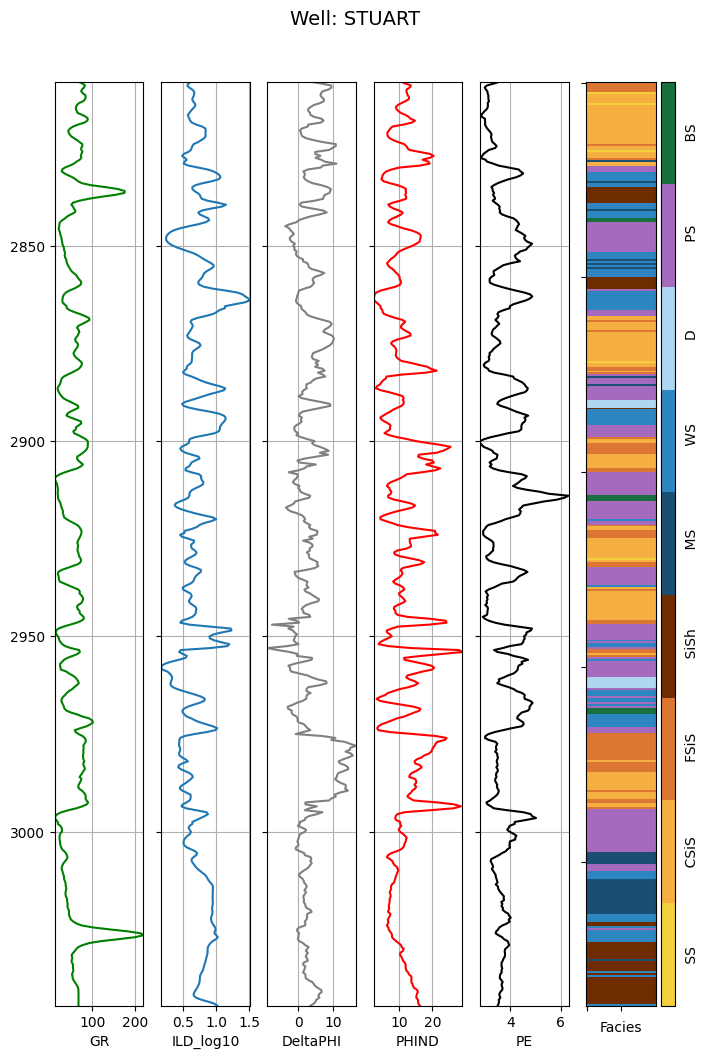

In [155]:
make_facies_log_plot(
    well_data_cb[well_data_cb['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

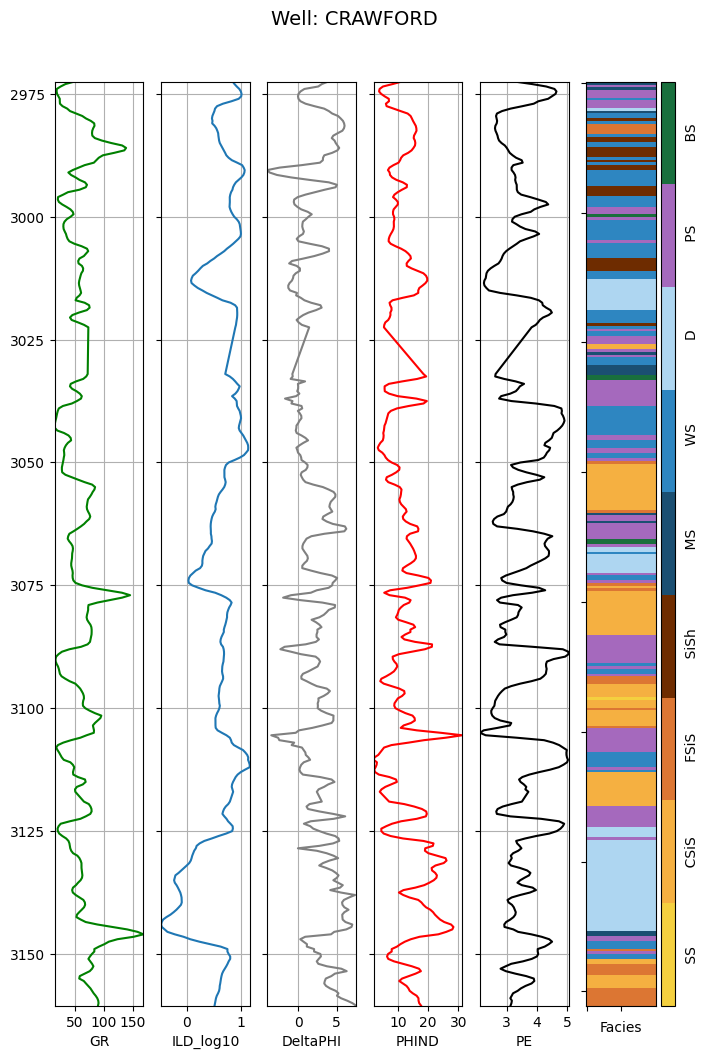

In [157]:
make_facies_log_plot(
    well_data_cb[well_data_cb['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)